<a href="https://colab.research.google.com/github/B-E-A-U-T-Y-K-U-M-A-R-I-S/Brain-Tumor-Classification/blob/main/brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
import cv2

In [3]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
files.upload()



Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"beautykumaris","key":"48478ce20fc1d3f51e8d66aa563f7454"}'}

In [4]:
!mkdir -p ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                      COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           8540        253  1.0              
mattop/alcohol-consumption-per-capita-2016                     Alcohol Consumption Per Capita 2016                   4KB  2022-12-09 00:03:11            770         28  1.0              
thedevastator/jobs-dataset-from-glassdoor                      Salary Prediction                                     3MB  2022-11-16 13:52:31           5479        119  1.0              
swaptr/fifa-world-cup-2022-statistics                          FI

In [8]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

brain-tumor-classification-mri.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!ls
!unzip brain-tumor-classification-mri.zip
!ls

 brain-tumor-classification-mri.zip   kaggle.json   Testing
'kaggle (1).json'		      sample_data   Training
Archive:  brain-tumor-classification-mri.zip
replace Testing/glioma_tumor/image(1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename:  brain-tumor-classification-mri.zip   kaggle.json   Testing
'kaggle (1).json'		      sample_data   Training


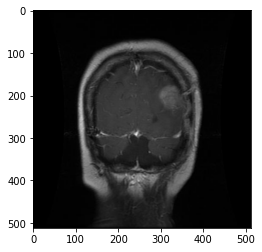

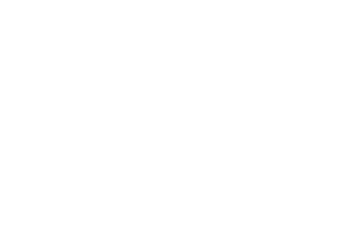

In [10]:
DATA = r"/content/Training" #reading the data
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"] #defining the 4 categories that we have
for category in CATEGORIES:
    path = os.path.join(DATA,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
        plt.show()
        plt.axis("off")
        break
    break

(-0.5, 149.5, 149.5, -0.5)

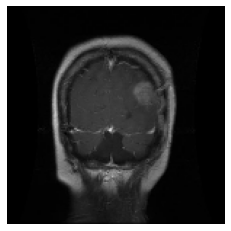

In [11]:
IMG_SIZE = 150 #defining our image size
new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))#scaling down our images  
plt.imshow(new_array,cmap = "gray")
plt.axis("off")

In [12]:
training_data = [] #manipulating our training data

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATA,category)
        class_num = CATEGORIES.index(category) #defining the different categories of the images in our data
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE) #loading the images in grayscale
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                training_data.append([new_array,class_num]) #adding our data in to the training_data list which we will use to define our X and y for train-tets split
            except Exception as e:
                pass
create_training_data()

In [13]:
X = [] #used for storing  the features
y = [] #used for storing the labels
for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE)
#print(X.shape)
X = X/255.0  
X = X.reshape(-1,150,150,1)
print(X.shape)

(2870, 150, 150, 1)


In [14]:
from keras.utils.np_utils import to_categorical #one-hot eencoding our values
y = to_categorical(y, num_classes = 4)

In [15]:
from sklearn.model_selection import train_test_split #splitting the data into training and validaton set
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (2296, 150, 150, 1)
x_test shape (574, 150, 150, 1)
y_train shape (2296, 4)
y_test shape (574, 4)


In [16]:
#defining our model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])
epochs = 13 
batch_size = 40
datagen = ImageDataGenerator(  
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,  
        height_shift_range=0,  
        horizontal_flip=True,  
        vertical_flip=False)  

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
model.summary() #checking what our final model would look like

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 128)       0

In [18]:
datagen.fit(X_train)
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val))    

Epoch 1/15


<ipython-input-18-50cd027b851d>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),


58/58 [==============================] - 275s 5s/step - loss: 1.2500 - accuracy: 0.4186 - val_loss: 1.0715 - val_accuracy: 0.5035
Epoch 2/15
58/58 [==============================] - 271s 5s/step - loss: 0.9636 - accuracy: 0.5875 - val_loss: 0.8264 - val_accuracy: 0.6237
Epoch 3/15
58/58 [==============================] - 273s 5s/step - loss: 0.7744 - accuracy: 0.6755 - val_loss: 0.6905 - val_accuracy: 0.7038
Epoch 4/15
58/58 [==============================] - 274s 5s/step - loss: 0.6807 - accuracy: 0.7095 - val_loss: 0.6145 - val_accuracy: 0.7387
Epoch 5/15
58/58 [==============================] - 276s 5s/step - loss: 0.5803 - accuracy: 0.7530 - val_loss: 0.5379 - val_accuracy: 0.7700
Epoch 6/15
58/58 [==============================] - 273s 5s/step - loss: 0.5095 - accuracy: 0.7831 - val_loss: 0.5826 - val_accuracy: 0.7369
Epoch 7/15
58/58 [==============================] - 273s 5s/step - loss: 0.4659 - accuracy: 0.8118 - val_loss: 0.4380 - val_accuracy: 0.8380
Epoch 8/15
58/58 [======

Text(0.5, 0, 'epoch')

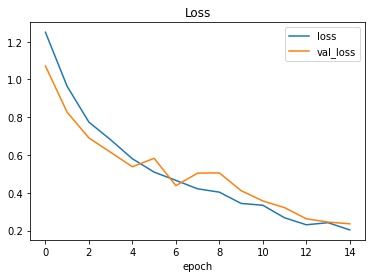

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

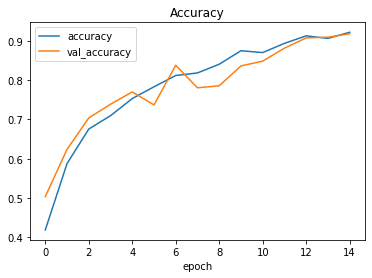

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')


In [21]:
model.save('BrainTumor.h5')

In [ ]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 761 kB 12.7 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.2.1-py3-none-any.whl size=19792 sha256=ba76e4afa25cdeb22ba34d2cdef70705f06484b584fd3d46fdd8bf7c24c2c452
  Stored in directory: /root/.cache/pip/wheels/5d/f2/70/526da675d32f17577ec47ac4c663084efe39d47c826b6c3bb1
Successfully built pyngrok


In [ ]:
!ngrok authtoken 2I8ohMfH45KOqng7EaPdLJBFvLX_3kCm1Sk6ciXmHwxUQkbch

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
!pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.2 MB 16.7 MB/s 
     |████████████████████████████████| 4.7 MB 65.7 MB/s 
     |████████████████████████████████| 237 kB 64.2 MB/s 
     |████████████████████████████████| 164 kB 55.8 MB/s 
     |████████████████████████████████| 78 kB 8.0 MB/s 
     |████████████████████████████████| 182 kB 53.0 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 51 kB 7.3 MB/s 
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=7c920200eee3092cef501abd57c0e298c28a6de9322a3d9e68a990e668c1b06e
  Stored in directory: /root/.cache/pip/wheels/19/09/72/3eb74d236bb48bd0f3c6c3c83e4e0c5bbfcbcad7c6c3539db8
Successfully built validators


In [ ]:
%%writefile app.py
import streamlit as st #importing streamlit and tensorflow
import tensorflow as tf
import cv2
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
import numpy as np
from PIL import Image ,ImageOps


st.set_option('deprecation.showfileUploaderEncoding',False) #on loading a streamlit app we get a warning, this line prevents us from getting that warning

@st.cache(allow_output_mutation=True) #this line prevent us from loading the model again and again and will help in storing the model in cache once it has been loaded

def load_model(): #loading our model
  model = tf.keras.models.load_model('/content/BrainTumor.h5')
  return model

model = load_model()
#defining the header or title of the page that the user will be seeing

st.markdown("<h1 style='text-align: center; color: Black;'>Brain Tumor Classifier</h1>", unsafe_allow_html=True)
st.markdown("<h3 style='text-align: center; color: Black;'>All you have to do is Upload the MRI scan and the model will do the rest!</h3>", unsafe_allow_html=True)
st.markdown("<h4 style='text-align: center; color: Black;'></h4>", unsafe_allow_html=True)
st.sidebar.header("What is this Project about?")
st.sidebar.text("It is a Deep learning solution to detection of Brain Tumor using MRI Scans.")
st.sidebar.header("What does it do?")
st.sidebar.text("The user can upload their MRI scan and the model will try to predict whether or not the user has Brain Tumor or not.")
st.sidebar.header("What tools where used to make this?")
st.sidebar.text("The Model was made using a dataset from Kaggle along with using Kaggle notebooks to train the model. We made use of Tensorflow, Keras as well as some other Python Libraries to make this complete project. To deply it on web, we used ngrok and Streamlit!")



file=st.file_uploader("Please upload your MRI Scan",type = ["jpg","png"]) #accepting the image input from the user

def import_and_predict(image_data,model): #our prediction method that will accept the data and the model and would give us a prediction
  size = (150,150)
  image1 = ImageOps.fit(image_data,size,Image.ANTIALIAS)
  image = ImageOps.grayscale(image1)
  img = np.asarray(image)
  img_reshape = img[np.newaxis,...]
  #img_reshape = img_reshape/255.0
  img_reshape = img.reshape(1,150,150,1)
  prediction = model.predict(img_reshape)
  return prediction

if file is None:
  st.markdown("<h5 style='text-align: center; color: Black;'>Please Upload a File</h5>", unsafe_allow_html=True)
else:
  image = Image.open(file)
  st.image(image,use_column_width = True)
  predictions = import_and_predict(image,model)
  class_names = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']
  string = "The patient most likely has:"+ class_names[np.argmax(predictions)]
  st.success(string)
  #st.success(predictions)

Writing app.py


In [ ]:
!ls

app.py				    BrainTumor.h5  sample_data	Training
brain-tumor-classification-mri.zip  kaggle.json    Testing


In [ ]:
!pip install -q streamlit

In [ ]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 2.238s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



In [ ]:
!streamlit run /content/app.py &>/content/logs.txt &

In [ ]:
!npx localtunnel --port 8501

npx: installed 22 in 2.549s
your url is: https://clean-goats-fix-34-141-185-64.loca.lt
